In [1]:
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat, savemat
from scipy import signal
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.optimizers import Adam, SGD
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, Softmax, Lambda, Reshape, BatchNormalization
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keras.layers import Layer

In [2]:
a = np.array([[1,2,3,8],[4,5,6,34],[7,8,9,10]])
print(a)
b = np.reshape(a, (1,-1))
print(b)
c = np.reshape(b, (-1, 3))

[[ 1  2  3  8]
 [ 4  5  6 34]
 [ 7  8  9 10]]
[[ 1  2  3  8  4  5  6 34  7  8  9 10]]


In [3]:
data1 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean5.npz')

In [4]:
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'], data4['Time'], data5['Time']), axis=None) #
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)


In [5]:
train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0) # 
print(train_data)
print(np.shape(train_data))

[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)


In [6]:
del data1, data2, data3, data4, data5

In [7]:
# full_data = np.hstack((ttime, train_data))
# print(full_data)
# print(np.shape(full_data))

ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

            Time   0   1    2    3    4  ...  1562  1563  1564  1565  1566  1567
0        2102.67  21   9   26   20   31  ...   -11   -14   -25   -31   -33   -45
1        2102.67  17  20   28   24   29  ...   -10   -19   -26   -25   -30   -41
2        2102.67   8  10   17   13   32  ...   -15   -15   -19   -17   -20   -38
3        2102.67   2   5   14    8   17  ...    10     5   -18   -21   -35   -40
4        2102.67  15  15   10   22   29  ...   -13   -18   -18   -17   -24   -38
...          ...  ..  ..  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...
1324027  3426.95  24  22   18   36   36  ...   250   258   253   233   231   232
1324028  3426.96  24  16   21   32   31  ...   261   246   255   245   232   227
1324029  3426.96  21  30   29   30   25  ...   264   264   246   232   242   238
1324030  3426.96  27  10   20   29   28  ...   265   252   258   248   239   228
1324031  3426.96  58  93  111  124  115  ...   265   248   245   249   224   216

[1324032 rows x 1569 column

In [8]:
# xx = pd.DataFrame([[1,3],[2,3],[6,8],[4,7],[5,8]])
# print(xx)
# print(xx.rolling(3, min_periods=1).mean().astype('float32'))
# print(xx.ewm(alpha=0.1, min_periods=1).mean())

In [9]:
# full_df = full_df.groupby(by='Time').mean().astype('float32').reset_index(drop=True)
# full_df['Time'] = full_df['Time'].shift(-1).fillna(truncate(full_df.iloc[-1,0]+0.01,2))

full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)


         0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
Time                                         ...                                    
2102.67    18    19     8    24    22    31  ...    -7   -13   -26   -29   -40   -47
2102.68    11    13    13    17    35    33  ...   -12   -18   -24   -25   -35   -38
2102.69    23    30    23    38    37    39  ...    -9   -18   -21   -25   -27   -38
2102.70    18    18    25    22    35    41  ...   -12   -16   -17   -22   -30   -30
2102.71    16    14    22    29    43    46  ...    -7    -5   -15   -28   -14   -36
...       ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
3426.92    24    15    13    25    32    32  ...   249   249   246   244   248   236
3426.93    16    15    27    21    49    32  ...   256   251   237   249   248   235
3426.94    11     1     6    17    23    28  ...   249   246   264   250   243   237
3426.95    24    22    18    36    36    26  ...   250   258   25

In [10]:
# full_df2 = full_df.rolling(40, min_periods=1).mean().astype('float32')
# print(full_df2)

In [11]:
# for i in range(0,1000,200):
#   fig = plt.figure(i, figsize=(10,3))
#   # plt.plot(full_df.iloc[-4000:,i])
#   plt.plot(full_df2.iloc[-4000:,i])
#   plt.legend(['Unfiltered Data', 'Filtered Data'])
#   plt.ylabel('Amplitude')
#   plt.xlabel('Time')

# print(full_df2.loc[[2121.74]].values.ravel())
# fig = plt.figure(3, figsize=(20,5))
# plt.plot(full_df.loc[[3385.26]].values.ravel(), '.')
# plt.plot(full_df2.loc[[3385.26]].values.ravel(), '.')

In [12]:
# full_df3 = full_df.ewm(alpha=0.05, min_periods=1, adjust=False).mean().astype('float32')
# print(full_df3)

In [13]:
data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
m_t = m_t[:][175604:175604+132400].reset_index(drop=True)
print(m_t)

           Time        SS
0       2102.91  5.657157
1       2102.92  5.658317
2       2102.93  5.659499
3       2102.94  5.660404
4       2102.95  5.661648
...         ...       ...
132395  3426.86  5.474545
132396  3426.87  5.478286
132397  3426.88  5.481751
132398  3426.89  5.484813
132399  3426.90  5.487332

[132400 rows x 2 columns]


In [14]:
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
xdf = df.drop(['Time', 'SS'], axis=1)
ydf = df[['SS']]
print(xdf)
print(ydf)


        0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
0          3    12    15    20    46    28  ...    -6   -11   -16   -23   -31   -40
1         15    16    13    29    33    39  ...    -6    -9   -15   -15   -25   -42
2          9    18     9    28    44    29  ...   -15   -13   -23   -27   -28   -25
3         22    31    17    24    41    27  ...    -3    -6   -18   -25   -24   -28
4         18    17    19    17    37    35  ...   -18   -16   -20   -26   -35   -44
...      ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
132370    25    37    15    19    39    30  ...   256   246   251   242   224   227
132371    20    14     7    10    27    18  ...   258   259   245   238   230   231
132372    22     9    17    27    33    29  ...   260   249   235   241   234   219
132373    14    19    17    25    33    36  ...   259   260   252   253   256   235
132374    28    23    20    34    31    33  ...   251   244   237   236   22

In [15]:
# xdf2 = xdf.values
# xdf2 = np.reshape(xdf2, (1,-1))
# fig = plt.figure(1, figsize=(15,3))
# plt.plot(xdf2[0][:10000])



In [18]:
# xdf1 = minmax_scale(np.array(xdf), axis=1, copy=False)
x_train, x_test1, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train1, X_val1, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

del x_train, y_train

print(X_train1.shape, X_val1.shape, x_test1.shape)
print(Y_train.shape, Y_val.shape, y_test.shape)

(95310, 1568) (10590, 1568) (26475, 1568)
(95310, 1) (10590, 1) (26475, 1)


In [19]:


X_train = np.reshape(X_train1.values, (-1,1))
X_val = np.reshape(X_val1.values, (-1,1))
x_test = np.reshape(x_test1.values, (-1,1))

del X_train1, X_val1, x_test1

# fig = plt.figure(1, figsize=(20,3))
# plt.plot(x_test[:5000])

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
x_test = sc.transform(x_test)

# fig = plt.figure(2, figsize=(20,3))
# plt.plot(x_test[:5000])

X_train = np.reshape(X_train, (-1,1568))
X_val = np.reshape(X_val, (-1,1568))
x_test = np.reshape(x_test, (-1,1568))

print(X_train.shape, X_val.shape, x_test.shape)
# fig = plt.figure(3, figsize=(20,3))
# plt.plot(x_test[10])


(95310, 1568) (10590, 1568) (26475, 1568)


In [20]:

X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(np.array(X_val), (X_val.shape[0], X_val.shape[1], 1))
x_test = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape, X_val.shape, x_test.shape)

(95310, 1568, 1) (10590, 1568, 1) (26475, 1568, 1)


In [21]:
def custom_layer(x):
  ret = tf.math.argmax(x, axis=1) 
  ret = tf.cast(ret, tf.float32)
  return ret


In [22]:
# class attention(Layer):
#     def __init__(self,**kwargs):
#         super(attention,self).__init__(**kwargs)

#     def build(self,input_shape):
#         self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
#         self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
#         super(attention, self).build(input_shape)

#     def call(self,x):
#         et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
#         at=K.softmax(et)
#         at=K.expand_dims(at,axis=-1)
#         output=x*at
#         return K.sum(output,axis=1)

#     def compute_output_shape(self,input_shape):
#         return (input_shape[0],input_shape[-1])

#     def get_config(self):
#         return super(attention,self).get_config()



class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

Epoch 1/15
2979/2979 [==============================] - 23s 7ms/step - loss: 3.1027 - val_loss: 0.0274
Epoch 2/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0172 - val_loss: 0.0225
Epoch 3/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0174 - val_loss: 0.0225
Epoch 4/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0177 - val_loss: 0.0215
Epoch 5/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0175 - val_loss: 0.0233
Epoch 6/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0175 - val_loss: 0.0226
Epoch 7/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 8/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0080 - val_loss: 0.0195
Epoch 9/15
2979/2979 [==============================] - 20s 7ms/step - loss: 0.0071 - val_loss: 0.0163
Epoch 10/15
2979/2979 [==============================] - 20s 7ms/step - l

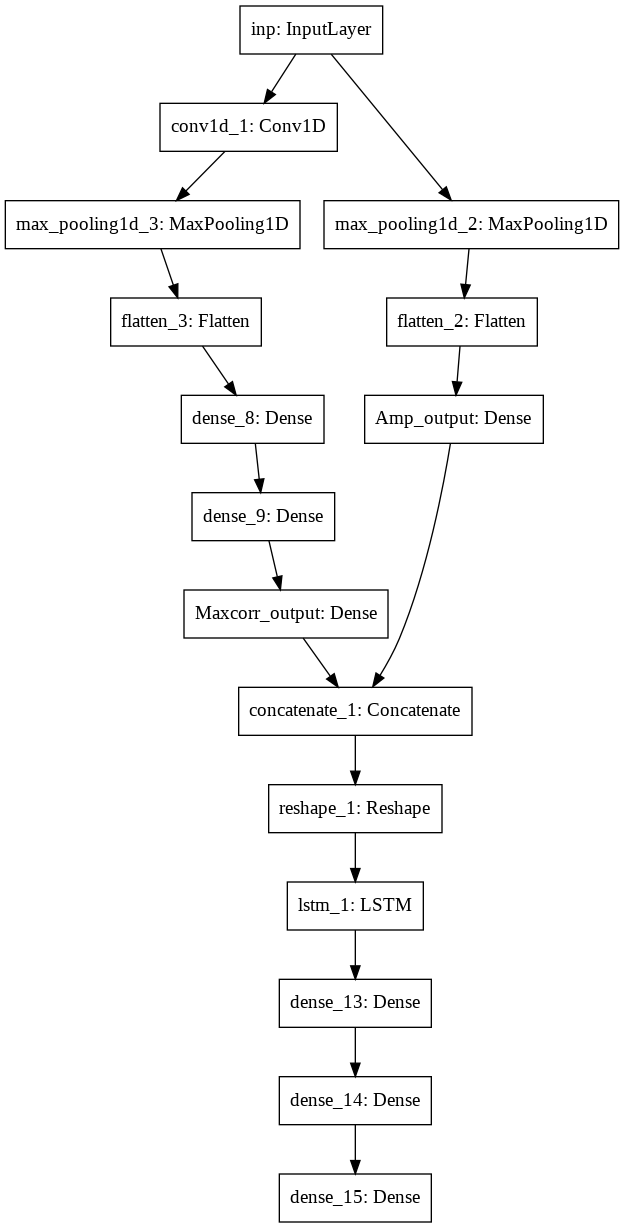

In [32]:

inp = Input(shape=(X_train.shape[1:]), name='inp')

# Amplitude
amp = MaxPooling1D(pool_size=100, strides=10, padding='valid', input_shape=(X_train.shape[1:]))(inp)
amp = Flatten()(amp)
amp = Dense(5, kernel_initializer='random_normal', name='Amp_output')(amp)

# Maxcorr 
corr = Conv1D(16, 256, strides=10, kernel_initializer='normal', activation=None, input_shape=(X_train.shape[1:]))(inp)
maxcorr = MaxPooling1D(pool_size=50, strides=16, padding='valid')(corr)
maxcorr = Flatten()(maxcorr)
maxcorr = Dense(32, kernel_initializer='random_normal', activation='relu')(maxcorr)
maxcorr = Dense(16, kernel_initializer='random_normal', activation='relu')(maxcorr)
# maxcorr = BatchNormalization()(maxcorr)
maxcorr = Dense(5, kernel_initializer='random_normal', name='Maxcorr_output')(maxcorr)

# TS
ts = Lambda(custom_layer)(corr)
ts = Dense(64, kernel_initializer='random_normal', activation=None)(ts)
ts = Dense(32, kernel_initializer='random_normal', activation=None)(ts)
ts = Dense(16, kernel_initializer='random_normal')(ts)
ts = Dense(5, name='TS_output', activation='sigmoid')(ts)

# Concatenate
c = Concatenate()([amp, maxcorr])
# c = Reshape((c.shape[1],1))(c)
# m = LSTM(32)(c)
#m = Attention(return_sequences=False)(m)
m = Dense(64, kernel_initializer = 'random_normal', activation='relu')(c)
m = Dense(32, kernel_initializer = 'random_normal', activation='relu')(m)
m = Dense(16, kernel_initializer = 'random_normal', activation='relu')(m)
# m = BatchNormalization()(m)
op = Dense(1, kernel_initializer = 'random_normal', activation=None)(m)
model = Model(inputs=[inp], outputs=[op])

model.compile(loss='mean_squared_error', optimizer=Adam())
model.fit(X_train, Y_train, batch_size=32, epochs=15, validation_data=(X_val, Y_val))
print(model.summary())
plot_model(model)


In [33]:
# Evaluate the model
y_predTrain = model.predict(X_train)
y_predTrain = pd.DataFrame(y_predTrain).rolling(20, min_periods=1).mean().astype('float32')
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
y_predVal = pd.DataFrame(y_predVal).rolling(20, min_periods=1).mean().astype('float32')
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  


start_time = time.time()
y_predTest = model.predict(x_test)
y_predTest = pd.DataFrame(y_predTest).rolling(20, min_periods=1).mean().astype('float32')
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))


print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R^2 scores:  0.719853719042171 0.723978105660869 -0.2514001511105297
RMSE:  0.06803428622556282 0.0768694898234911 0.16199213082261252

---Time for Test data prediction: 1.93493938 seconds ---


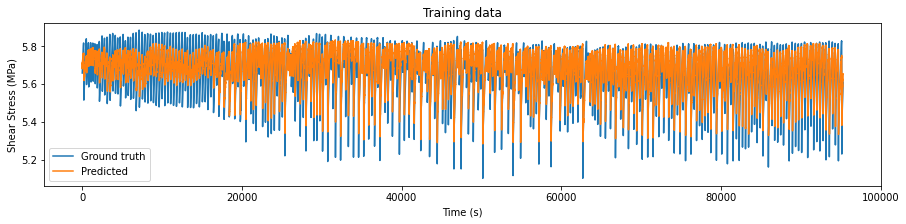

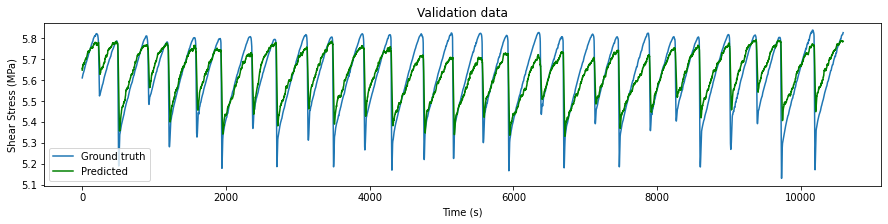

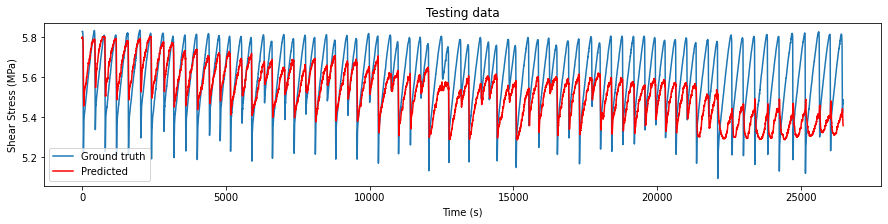

In [34]:
def results_plot(fig_no, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(15,3))
  plt.plot(gt)
  plt.plot(pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data', '')
results_plot(2, Y_val.values, y_predVal, 'Validation data', 'g')
results_plot(3, y_test.values, y_predTest, 'Testing data', 'r')

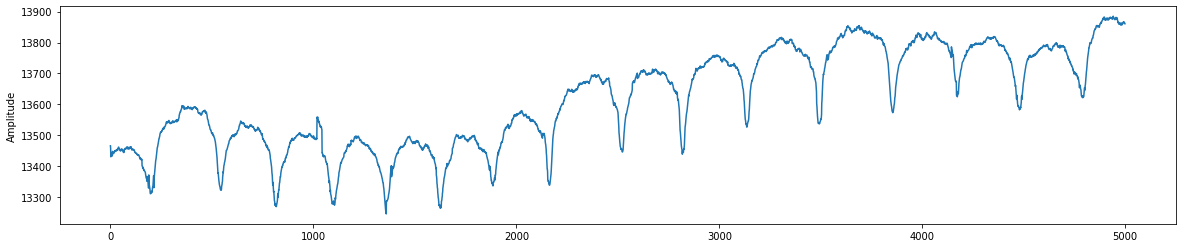

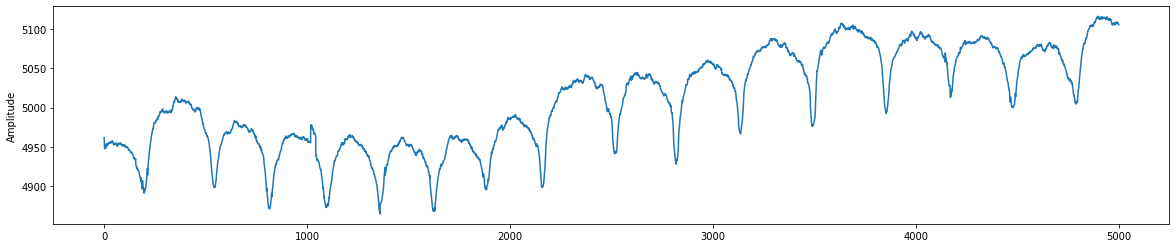

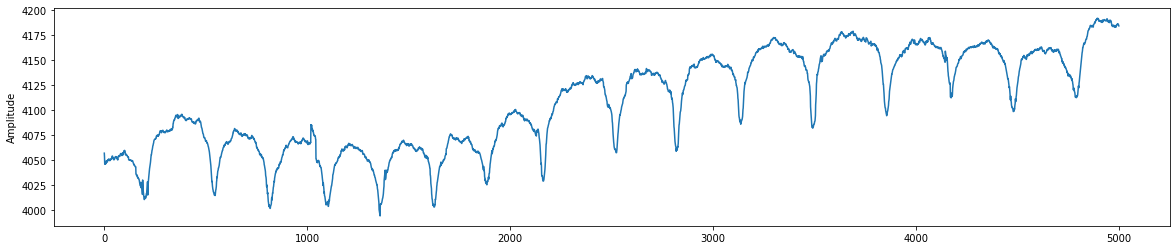

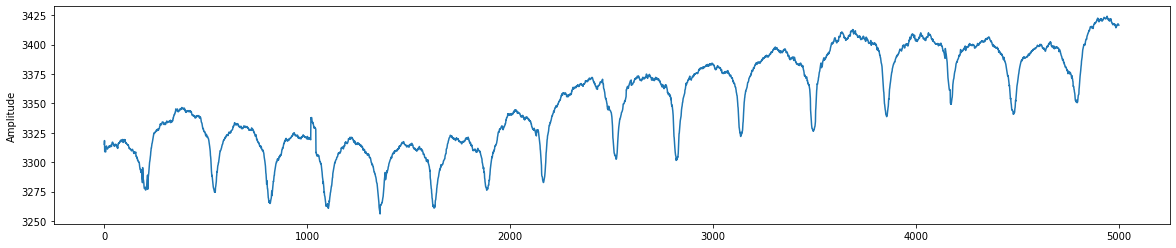

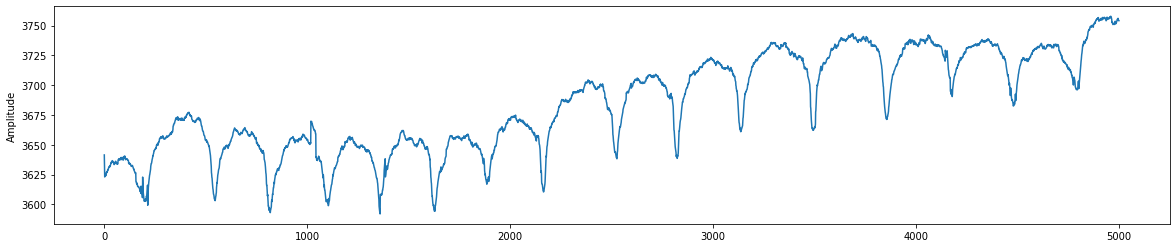

In [26]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Amp_output').output)
intermediate_output = intermediate_layer_model.predict(xdf)

for i in range(intermediate_output.shape[1]):
  fig = plt.figure(i, figsize=(20,4))
  amp = pd.DataFrame(intermediate_output.squeeze()[:,i][:5000]).rolling(25, min_periods=1).mean().astype('float32')
  plt.plot(amp)
  plt.ylabel('Amplitude')
  # plt.plot(df2['Amp'][:10000])


In [27]:
# intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('TS_output').output)
# intermediate_output = intermediate_layer_model.predict(xdf)

# for i in range(intermediate_output.shape[1]):
#   fig = plt.figure(i, figsize=(20,4))
#   ts = pd.DataFrame(intermediate_output.squeeze()[:,i][:5000]).rolling(30, min_periods=1).mean().astype('float32')
#   plt.plot(ts)
#   plt.ylabel('Time-Shift')

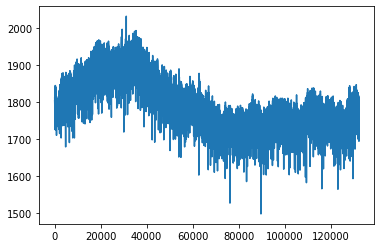

In [28]:

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/Results_p5270_run1_fullrun_Stack10WFs_mixref_Th0.97_wAmp_400kHz.mat')
df2 = pd.DataFrame({'Amp':data2['Amp'][3787:136186].ravel()})
plt.plot(df2['Amp'])

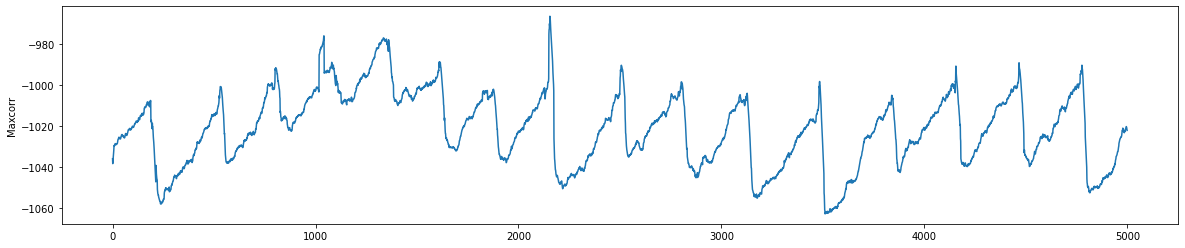

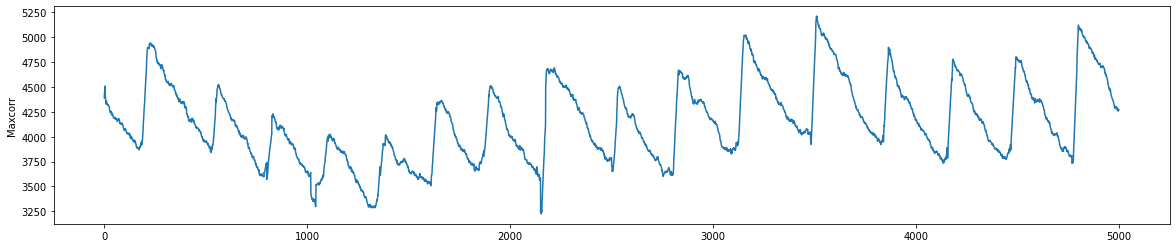

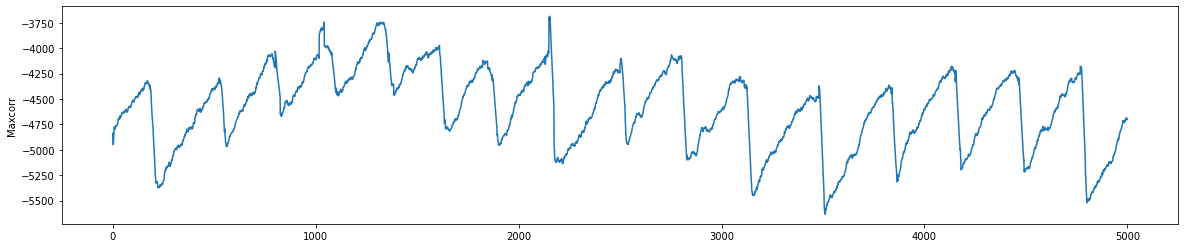

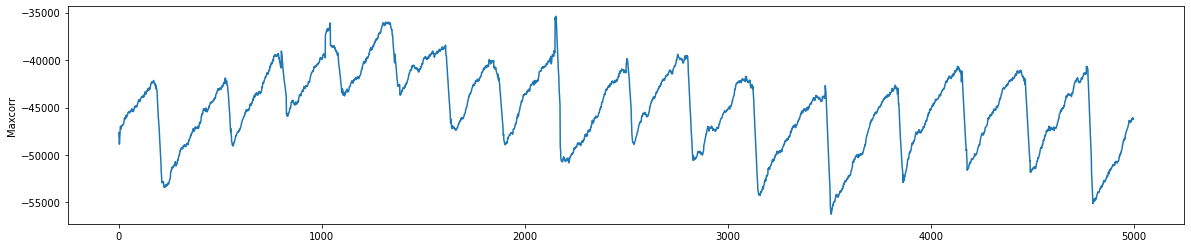

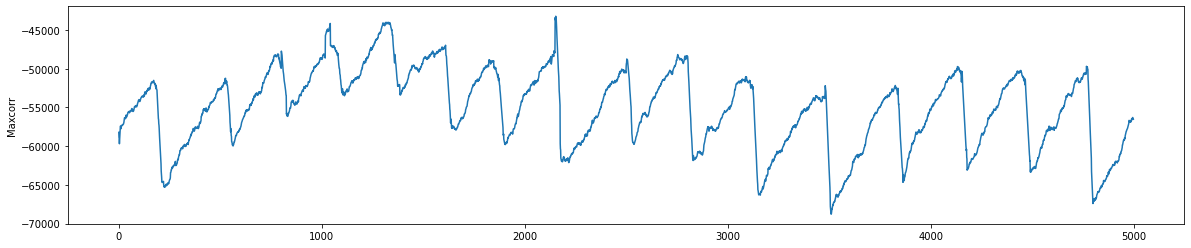

In [29]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Maxcorr_output').output)
intermediate_output = intermediate_layer_model.predict(xdf)

for i in range(intermediate_output.shape[1]):
  fig = plt.figure(i, figsize=(20,4))
  mc = pd.DataFrame(intermediate_output.squeeze()[:,i][:5000]).rolling(25, min_periods=1).mean().astype('float32')
  plt.plot(mc)
  plt.ylabel('Maxcorr')